# 시험장 환경 정보

Python: 3.7.4 (tags/v3.7.4:e09359112e, Jul  8 2019, 20:34:20) [MSC v.1916 64 bit (AMD64)]

|모듈|버젼|
|----|----|
|pandas|0.25.1|
|numpy|1.18.5|
|sklearn|0.21.3|
|scipy|1.5.2|
|mlxtend|0.15.0.0|
|statsmodels|0.11.1|

**강사: 멀티캠퍼스 강선구(sunku0316.kang@multicampus.com, sun9sun9@gmail.com)**

In [41]:
# 실행 환경 확인

import pandas as pd
import numpy as np
import sklearn
import scipy
import statsmodels
import mlxtend
import sys
import xgboost as xgb

print(sys.version)
for i in [pd, np, sklearn, scipy, mlxtend, statsmodels, xgb]:
    print(i.__name__, i.__version__)

3.7.4 (tags/v3.7.4:e09359112e, Jul  8 2019, 20:34:20) [MSC v.1916 64 bit (AMD64)]
pandas 0.25.1
numpy 1.18.5
sklearn 0.21.3
scipy 1.5.2
mlxtend 0.15.0.0
statsmodels 0.11.1
xgboost 0.80


In [42]:
# 시각화 모듈 설정
# 참고용 차트를 출력하기 위함
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl
import matplotlib.font_manager as fm
plt.rc('font', family='Malgun Gothic')
mpl.rcParams['axes.unicode_minus'] = False

# 문제 개요


생활가전 A부서는 친환경 미니 세탁기를 개발 중에 있다. 

프로젝트의 핵심은 세탁물을 자동 인식하고 이에 따른 최적 코스를 (수량, 수온, 세제종류, 세제량, 세탁시간, 세탁방법) 제시하여 세탁지수(target)를 높이는 것이다. 

이를 위해 세탁지수에 영향을 주는 빨랫감의 종류와 오염량, 급수량, 세제종류, 투입량 등을 측정한 데이터를 확보하였다. 

데이터의 변수명은 보안을 위해 cat0, cont0등으로 코드화 되어 있다.

아래 데이터를 사용하여 과제를 해결하고 세탁지수(target)를 예측하시오.

데이터 구성

학습데이터: train_prob.csv, 240,000 rows, 26 columns

테스트데이터: test_prob.csv, 60,000 rows, 25 columns

테스트정답셋: test_prob_ans.csv, 60,000 rows, 1 columns

|변수명|설명|타입|
|------|----|----|
|Id|실험 고유 번호|정수형|
|cat0 ~ cat9|범주형 변수 0~9|문자형|
|cont0 ~ cont13|연속형 변수 0~13|실수형|
|target|세탁지수|실수형|


# 전처리(Preprocessing)

train_prob.csv 데이터셋을 대상으로 다음 전처리를 진행하라.

In [43]:
df_train = pd.read_csv('train_prob.csv', index_col='id')
display(df_train.head())
df_train.info()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
id,,,,,,,,,,,,,,,,,,,,,
267387,A,B,B,C,B,B,A,E,G,G,...,0.22443,0.69220,0.30912,0.47134,0.53290,0.97139,0.59414,0.36856,0.42951,8.13741
410037,A,A,A,A,B,B,A,E,C,F,...,0.43278,0.97199,0.62596,0.40193,0.49181,0.56479,0.39386,0.36247,0.71541,7.40427
139373,A,A,B,A,B,B,A,E,C,J,...,0.36238,0.41310,0.27010,0.40112,0.53052,0.35635,0.33341,0.33354,0.82542,7.98022
113765,A,A,A,C,B,B,A,E,C,G,...,0.32670,0.42301,0.28331,0.46425,0.38302,0.38054,0.68827,0.34895,0.73375,7.26085
179915,A,B,A,C,B,B,A,E,E,L,...,0.20121,0.37466,0.46316,0.75578,0.55676,0.31308,0.43157,0.32302,0.18028,7.26448


<class 'pandas.core.frame.DataFrame'>
Int64Index: 240000 entries, 267387 to 415856
Data columns (total 25 columns):
cat0      240000 non-null object
cat1      240000 non-null object
cat2      240000 non-null object
cat3      240000 non-null object
cat4      240000 non-null object
cat5      240000 non-null object
cat6      240000 non-null object
cat7      240000 non-null object
cat8      240000 non-null object
cat9      240000 non-null object
cont0     240000 non-null float64
cont1     240000 non-null float64
cont2     240000 non-null float64
cont3     240000 non-null float64
cont4     240000 non-null float64
cont5     240000 non-null float64
cont6     240000 non-null float64
cont7     240000 non-null float64
cont8     240000 non-null float64
cont9     240000 non-null float64
cont10    240000 non-null float64
cont11    240000 non-null float64
cont12    240000 non-null float64
cont13    240000 non-null float64
target    240000 non-null float64
dtypes: float64(15), object(10)
memory usage

## 단계 1

target은 2개의 정규 분포가 합쳐진 모양을 하고 있다. 

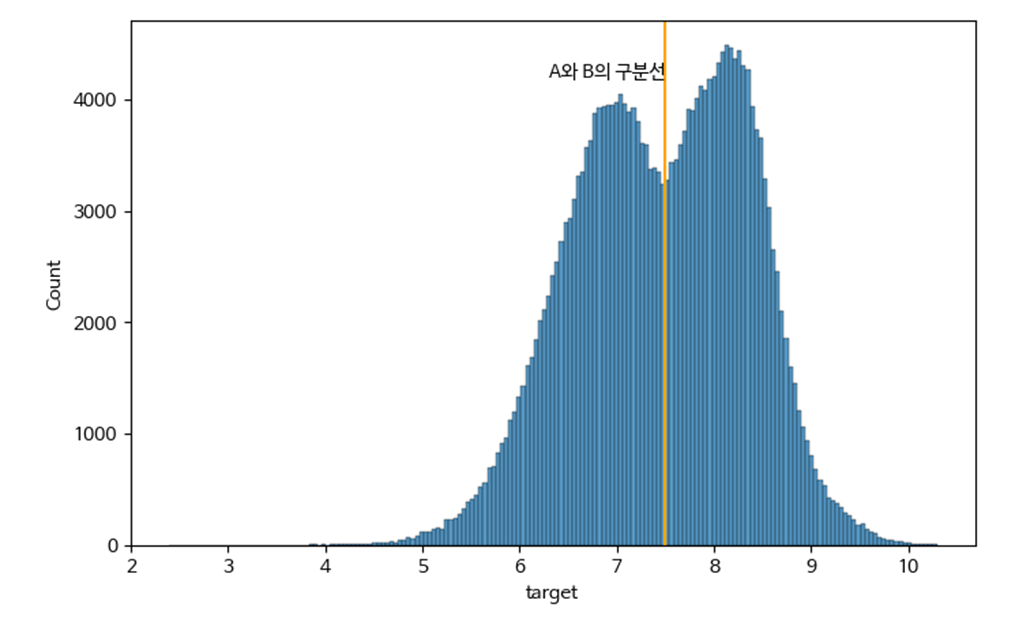

두 분포의 구분점 7.45를 기준으로 target값이 작거나 같으면 A, 초과하면 B로 나눈다.

A 범주이면 True, B이면 False인 파생 변수 target A를 만든다.

In [44]:
df_train['targetA'] = df_train['target'] <= 7.45

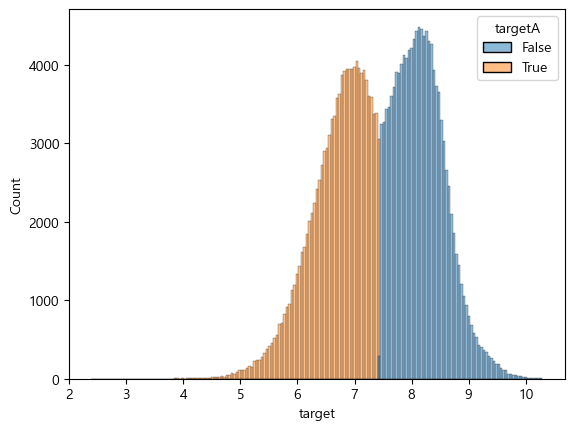

In [45]:
sns.histplot(df_train, x='target', hue='targetA')
plt.show()

## 단계 2

cat3 ~ 9 각각의 범주 중에서 빈도가 적은 범주를 target을 예측하는데 영향이 없는 방향으로 정리하려고 한다. 

아래 가이드에 맞추어 cat3 ~ 9 에 대한 전처리를 수행한다.

* cat3는 B→C 로 치환한다.

Hint] 치환 후의 빈도 테이블

|A|C|D|
|-|-|-|
|83,634|147,361|9,005|

* cat4는 A→B, D→B 로 치환한다.

Hint] 치환 후의 빈도 테이블

|B|C|
|-|-|
|239,397|603|

* cat6는 D→A, E→B, G→C, H→B, I→A로 치환한다.

Hint] 치환 후의 빈도 테이블

|A|B|C|
|-|-|-|
|234,203|5,145|652|

* cat7는 A→B, C→B, F→D, I→B로 치환한다.

Hint] 치환 후의 빈도 테이블

|B|D|E|G|
|-|-|-|-|
|4,606|19,784|214,027|1,583|

* cat8는 B→G, F→E로 치환한다.

Hint] 치환 후의 빈도 테이블

|A|C|D|E|G|
|-|-|-|-|-|
|30,338|96,743|2,953|76,085|33,881|

* cat9는 C→H, D→B, E→L로 치환한다.

Hint] 치환 후의 빈도 테이블

|A|B|F|G|H|I|J|K|L|M|N|O|
|-|-|-|-|-|-|-|-|-|-|-|-|
|10,678|2,846|85,944|8,320|19,987|40,070|5,501|16,743|33,793|7,819|3,331|4,968|

범주형 변수들(cat0\~9)을 **cat_cols**, 연속형 변수(cont0\~13)들을 **cont_cols** 로 정의합니다.

전처리 과정을 마친 데이터프레임을 **basetable**이라고 합니다.

In [46]:
repl_list = [
    ('cat3', {'B': 'C'}, [83634, 147361, 9005]),
    ('cat4', {'A': 'B', 'D': 'B'}, [239397, 603]),
    ('cat6', {'D': 'A', 'E': 'B', 'G': 'C', 'H': 'B', 'I': 'A'}, [234203, 5145, 652]),
    ('cat7', {'A': 'B', 'C': 'B', 'F': 'D', 'I': 'B'}, [4606, 19784, 214027, 1583]),
    ('cat8', {'B': 'G', 'F': 'E'}, [30338, 96743, 2953, 76085, 33881]),
    ('cat9', {'C': 'H', 'D': 'B', 'E': 'L'}, [10678, 2846, 85944, 8320, 19987, 40070, 5501, 16743, 33793, 7819, 3331, 4968])
]

for c, d, cnt in repl_list:
    print(c, d, cnt)
    s_repl = df_train[c].replace(d)
    if (s_repl.nunique() != len(cnt)) or (s_repl.value_counts().sort_index() != cnt).any():
        print('error', s_repl.value_counts().sort_index())
        break
    df_train[c] = s_repl

cat3 {'B': 'C'} [83634, 147361, 9005]
cat4 {'A': 'B', 'D': 'B'} [239397, 603]
cat6 {'D': 'A', 'E': 'B', 'G': 'C', 'H': 'B', 'I': 'A'} [234203, 5145, 652]
cat7 {'A': 'B', 'C': 'B', 'F': 'D', 'I': 'B'} [4606, 19784, 214027, 1583]
cat8 {'B': 'G', 'F': 'E'} [30338, 96743, 2953, 76085, 33881]
cat9 {'C': 'H', 'D': 'B', 'E': 'L'} [10678, 2846, 85944, 8320, 19987, 40070, 5501, 16743, 33793, 7819, 3331, 4968]


In [31]:
cat_cols = ['cat{}'.format(i) for i in range(10)]
cont_cols = ['cont{}'.format(i) for i in range(14)]
df_basetable = df_train.copy()
(
    np.array(cat_cols),
    np.array(cont_cols)
)

(array(['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7',
        'cat8', 'cat9'], dtype='<U4'),
 array(['cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6',
        'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13'],
       dtype='<U6'))

**TIP!**: Dunn Index 구하기
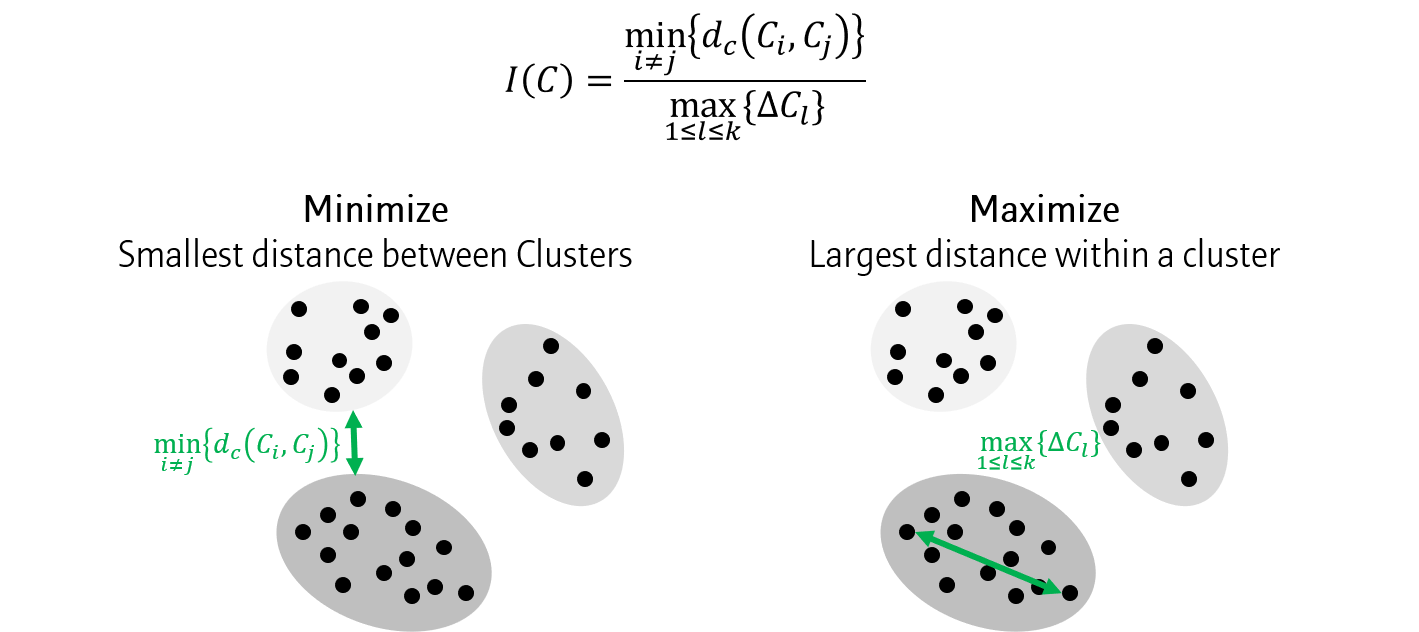

**Question**

cat5는 cont0~13 연속형 변수에 대한 군집화의 결과 생긴 데이터 포인트의 소속 군집이라고 가정합니다.

**df_basetable**에서 1%를 뽑아 **df_dunn**을 만듭니다. (pd.DataFrame.sample(frac=0.01, random_state=123))

**df_dunn**에서 cat5 군집에 대한 Dunn-Index로 측정하세요.

**Python 함수가이드**

```python
from scipy.spatial.distance import pdist, cdist, squareform
```

In [ ]:
df_dunn = df_basetable.sample(frac=0.01, random_state=123)
df_dunn.shape

In [ ]:
from scipy.spatial.distance import pdist, cdist, squareform

squareform(pdist(df_dunn[cont_cols]))

In [ ]:
cdist(df_dunn.loc[df_dunn['cat5'] == 'B', cont_cols], df_dunn.loc[df_dunn['cat5'] == 'D', cont_cols])

In [73]:
from scipy.spatial.distance import pdist, cdist, squareform

result = {}
for i in df_dunn['cat5'].unique():
    result[i] = np.max(pdist(df_dunn.loc[df_dunn['cat5'] == i, cont_cols]))
max_diam = pd.Series(result).max()

In [72]:
max_diam = df_dunn.groupby('cat5')[cont_cols].apply(
    lambda x: np.max(pdist(x))
).max()
max_diam

2.2012507003065327

In [77]:
min_dist = df_dunn.groupby('cat5')[cont_cols].apply(
    lambda x: np.min(cdist(x, df_dunn.loc[df_dunn['cat5'] != x.name, cont_cols]))
).min()
min_dist

0.17334836111137597

In [78]:
I_C = min_dist / max_diam
I_C

0.07874994024407876

**사용자 정의 척도**

pdist, cdist를 이용하여 SVR의 rbf 커널을 직접 만들어 봅니다.

In [87]:
df_dunn_test = df_basetable.sample(frac=0.01, random_state=124)
df_dunn.shape

(2400, 26)

In [81]:
# SVR의 RBF 커널을 pdist, cdist를 이용하여 만들어 봅니다.
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
reg_svr = SVR(kernel='rbf', gamma = 0.1, C=10)
reg_svr.fit(df_dunn[cont_cols], df_dunn['target'])
mean_squared_error(df_dunn_test['target'], reg_svr.predict(df_dunn[cont_cols]))

0.8230038199500778

RBF:

$k(x_i,x_j)=exp⁡(-\gamma ||x_i-x_j||^2 ),\gamma=0.1$

In [90]:
gamma = 0.1
reg_svr = SVR(kernel='precomputed', C=10)
reg_svr.fit(
    np.exp(squareform((pdist(df_dunn[cont_cols], lambda u, v: ((u - v) ** 2).sum()))) * -gamma), df_dunn['target']
)

SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='precomputed', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [91]:
mean_squared_error(
    df_dunn_test['target'], 
    reg_svr.predict(np.exp((cdist(df_dunn_test[cont_cols], df_dunn[cont_cols]) ** 2) * -gamma))
)

0.8230038199500791

**TIP** xgb.XGBRegressor custom loss function을 적용해 봅니다.

**df_dunn**에서 **cont_cols**를 입력변수로 하고 target을 예측하는 모델을 

아래 손실함수를 사용하여 xgb.XGBRegressor를 학습시킵니다.

$L(y_i, \hat{y_i}) = \frac{1}{2}(y_i - \hat{y_i})^2$

xgb.XGBRegressor 가이드에 의하면, 

```
A custom objective function can be provided for the ``objective``
parameter. In this case, it should have the signature
``objective(y_true, y_pred) -> grad, hess``:

y_true: array_like of shape [n_samples]
    The target values
y_pred: array_like of shape [n_samples]
    The predicted values

grad: array_like of shape [n_samples]
    The value of the gradient for each sample point.
hess: array_like of shape [n_samples]
    The value of the second derivative for each sample point
```

이를 위해서는 Gradient와 Hessian을 구해야 합니다. 

$\frac{\partial L(y_i, F(x_i))}{\partial F(x_i)} = -(y_i - F(x_i))$

$\frac{\partial ^2 L(y_i, F(x_i))}{\partial ^2 F(x_i)} = 1$

In [202]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
def custom_mse_loss(y_true, y_prd):
    return (y_prd - y_true), np.ones_like(y_true)

reg_xgb = xgb.XGBRegressor(
    objective=custom_mse_loss
)
reg_xgb.fit(df_dunn[cont_cols], df_dunn['target'])
mean_squared_error(df_dunn['target'], reg_xgb.predict(df_dunn[cont_cols]))

0.6040788088560752

In [200]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

reg_xgb = xgb.XGBRegressor()
reg_xgb.fit(df_dunn[cont_cols], df_dunn['target'])
mean_squared_error(df_dunn['target'], reg_xgb.predict(df_dunn[cont_cols]))

0.6040788088560752

# 문제1

범주형 변수의 조합의 특성을 파악하고자 한다. 다음 과정을 수행하라.

## 단계 1-1

basetable을 복사하여 prob1을 만들고 cat0 ~ 9 변수 순서대로 문자열 결합하여, 10자리 문자형 파생 변수(cat_c)를 생성하라.

In [94]:
# 방법 1: 문자열에 대한 sum
df_prob1 = df_basetable.assign(
    cat_c = lambda x: x[cat_cols].sum(axis=1)
)
df_prob1.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target,targetA,cat_c
id,,,,,,,,,,,,,,,,,,,,,
267387,A,B,B,C,B,B,A,E,G,G,...,0.30912,0.47134,0.53290,0.97139,0.59414,0.36856,0.42951,8.13741,False,ABBCBBAEGG
410037,A,A,A,A,B,B,A,E,C,F,...,0.62596,0.40193,0.49181,0.56479,0.39386,0.36247,0.71541,7.40427,True,AAAABBAECF
139373,A,A,B,A,B,B,A,E,C,J,...,0.27010,0.40112,0.53052,0.35635,0.33341,0.33354,0.82542,7.98022,False,AABABBAECJ
113765,A,A,A,C,B,B,A,E,C,G,...,0.28331,0.46425,0.38302,0.38054,0.68827,0.34895,0.73375,7.26085,True,AAACBBAECG
179915,A,B,A,C,B,B,A,E,E,L,...,0.46316,0.75578,0.55676,0.31308,0.43157,0.32302,0.18028,7.26448,True,ABACBBAEEL


In [104]:
# 방법2: apply(axis=1) pd.Series.str.cat
df_prob1 = df_basetable.assign(
    cat_c = df_prob1[cat_cols].apply(lambda x: x.str.cat(),axis=1)
)
df_prob1.head()

In [103]:
# 방법3: apply(axis=1) str.join
df_prob1 = df_basetable.assign(
    cat_c = df_prob1[cat_cols].apply(lambda x: ''.join(x), axis=1)
)
df_prob1.head()

## 단계 1-2

50개 이상 행으로 이루어지고, target에 대한 정규성을 부정할 수 없는 cat_c를 찾아 cat_c_A와 cat_c_B를 구하라. 

정규성 검정은 Kolmogolov-Smironov 검정을 사용한다. (유의 수준: 5%)

- cat_c의 행의 개수가 많은 순으로 cat_c 3개를 cat_c_A

- cat_c의 행의 개수가 적은 순으로 cat_c 3개를 cat_c_B

* 행의 개수가 같을 경우에는 p-value가 높은 순으로 고른다.

---
**함수가이드**

scipy.stats 제공 기능 활용

문제 지시사항 외 Default 값 사용

---


In [127]:
from scipy.stats import kstest, norm, zscore
from functools import partial
# kstest를 진행하는 방법을 정리합니다.
# 방법1: 입력 샘플을 zscore를 통한 표준화
# 방법2: 직접 표준화를 구현
# 방법3: kstest의 args를 통해 norm.cdf에 파라메터 전달
# 방법4: functools.partial로 norm.cdf에 파라메터 설정
(
    kstest((df_prob1['target'] - df_prob1['target'].mean()) / df_prob1['target'].std(), norm.cdf),
    kstest(zscore(df_prob1['target'], ddof=1), norm.cdf), 
    kstest(df_prob1['target'], norm.cdf, args=(df_prob1['target'].mean(), df_prob1['target'].std())),
    kstest(df_prob1['target'], partial(norm.cdf, loc=df_prob1['target'].mean(), scale=df_prob1['target'].std()))
)

(KstestResult(statistic=0.048494479307812144, pvalue=0.0),
 KstestResult(statistic=0.048494479307812144, pvalue=0.0),
 KstestResult(statistic=0.048494479307812144, pvalue=0.0),
 KstestResult(statistic=0.048494479307812144, pvalue=0.0))

In [111]:
# 50개 이상의 빈도를 지닌 cat_c의 샘플들만 가져오는 루틴입니다. 
# 이러한 루틴은 groupby ~ filter 로 간소화 시킬 수 있습니다.
df_prob1.loc[
    df_prob1['cat_c'].isin(
        df_prob1['cat_c'].value_counts().pipe(
            lambda x: x.loc[x >= 50]
        ).index
    )
]

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target,targetA,cat_c
id,,,,,,,,,,,,,,,,,,,,,
410037,A,A,A,A,B,B,A,E,C,F,...,0.62596,0.40193,0.49181,0.56479,0.39386,0.36247,0.71541,7.40427,True,AAAABBAECF
113765,A,A,A,C,B,B,A,E,C,G,...,0.28331,0.46425,0.38302,0.38054,0.68827,0.34895,0.73375,7.26085,True,AAACBBAECG
179915,A,B,A,C,B,B,A,E,E,L,...,0.46316,0.75578,0.55676,0.31308,0.43157,0.32302,0.18028,7.26448,True,ABACBBAEEL
166456,A,A,A,C,B,B,A,E,E,F,...,0.26890,0.08374,0.26894,0.13828,0.34825,0.29079,0.28819,7.79397,False,AAACBBAEEF
29503,A,B,A,C,B,B,A,E,E,F,...,0.28413,0.30163,0.32551,0.26982,0.19329,0.39034,0.30002,6.66255,True,ABACBBAEEF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320975,A,A,A,C,B,B,A,E,C,I,...,0.62906,0.31427,0.43718,0.40494,0.69718,0.34519,0.67524,7.60537,False,AAACBBAECI
29591,A,B,A,C,B,B,A,E,C,F,...,0.82530,0.46395,0.83396,0.71724,0.69450,0.33008,0.28460,8.10343,False,ABACBBAECF
46717,A,B,B,C,B,D,A,E,G,F,...,0.79777,0.87541,0.63918,0.58994,0.77751,0.86388,0.74568,6.93285,True,ABBCBDAEGF


In [ ]:
# groupby ~ filter
df_prob1.groupby('cat_c').filter(lambda x: len(x) >= 50)['cat_c'].value_counts()

In [134]:
# 방법 1
# groupby ~ filter를 통해 50개 이상의 샘플을 지닌 cat_c의 샘플들만 골라냅니다.
# groupby ~ apply 를 통해 cat_c 각각의 target 샘플에 대한 Kolmogorov Smironof 검정을합니다.
# KS-test 시 norm.cdf의 기본설정이 loc=0, scale(표준편차)=1인 만큼 
# 분포의 형태를 검증하는 만큼 대상 샘플을 표준화를 하여 평균과 표준편차(표본표준편차, ddof=1)를 
# norm.cdf 형태와 맞추어 줍니다.
# 빈도수도 결합해줍니다.

from scipy.stats import kstest, norm, zscore

df_kstest = df_prob1.groupby('cat_c').filter(lambda x: len(x) >= 50)\
    .groupby('cat_c')['target'].apply(
        lambda x: pd.Series(kstest(zscore(x, ddof=1), norm.cdf), index=['stat', 'pvalue'])
    ).unstack().join(df_prob1['cat_c'].value_counts().rename('cnt'))
df_kstest.head()

,stat,pvalue,cnt
cat_c,,,
AAAABBADAF,0.093664,0.548731,69
AAAABBADCF,0.075332,0.100458,259
AAAABBADCI,0.084878,0.705019,65
AAAABBADEF,0.093602,0.586496,65
AAAABBAEAA,0.051012,0.922963,110


In [ ]:
# 방법 2: 반복문

from scipy.stats import kstest, norm
# 결과를 저장하기 위한 list입니다.
ks_result = []
# value_counts로 cat_c의 빈도수를 가져옵니다.
# k(key)는 cat_c, v(value)는 빈도수가 됩니다.
for k, v in df_prob1['cat_c'].value_counts().items():
    # 빈도수에 대하여 내림 차순으로 넘어오기 때문에 
    # 50 미만일 경우에 요건에 맞추어 멈춥니다.
    if v < 50:
        break
    # 현재 라운드에 대한 kstest를 수행합니다.
    s_target = df_prob1.loc[df_prob1['cat_c'] == k, 'target']
    result = kstest((s_target - s_target.mean()) / s_target.std(), norm.cdf)
    # (cat_c, 검정통계량, pvalue, 빈도수) 튜플을 ks_restul_ 추가합니다.
    ks_result.append((k, result.statistic, result.pvalue, v))
df_kstest = pd.DataFrame(ks_result, columns=['cat_c', 'stat', 'pvalue', 'cnt']).set_index('cat_c')
df_kstest.head()

In [137]:
df_kstest = df_kstest.query('pvalue >= 0.05').sort_values(['cnt', 'pvalue'], ascending=[False, True])
df_kstest

,stat,pvalue,cnt
cat_c,,,
ABACBBAEEI,0.030799,0.054494,1888
AAAABBAEEI,0.040326,0.099566,914
AAACBDAEGI,0.044676,0.057831,880
AAACBBAEEA,0.045374,0.066533,819
AAACBBAEEH,0.036724,0.216905,814
...,...,...,...
ABBCBDAEEM,0.077785,0.899734,50
AAACBCAEEI,0.071563,0.943845,50
ABADBDAEAL,0.067553,0.964781,50


In [141]:
cat_c_A = df_kstest.iloc[:3].index.tolist()
cat_c_B = df_kstest.iloc[-3:].index.tolist()
cat_c_A, cat_c_B 

(['ABACBBAEEI', 'AAAABBAEEI', 'AAACBDAEGI'],
 ['ABADBDAEAL', 'BBAABDAEEF', 'ABBABBAECI'])

## 단계 1-3

bartlett 검정을 사용하여 cat_c_A에 해당하는 범주간에 target의 등분산성을 조사했을 때 검정 통계량을 A라 한다. 

그리고 bartlett 검정을 사용하여 cat_c_B에 해당하는 범주간에 target의 등분산성을 조사했을 때 검정 통계량을 B라고 한다. 


---
**함수가이드**

scipy.stats 제공 기능 활용

문제 지시사항 외 Default 값 사용

---

In [146]:
from scipy.stats import bartlett

result_1_3_1 = bartlett(*df_prob1.loc[df_prob1['cat_c'].isin(cat_c_A)].groupby('cat_c')['target'].agg(list))
A = result_1_3_1.statistic
result_1_3_2 = bartlett(*df_prob1.loc[df_prob1['cat_c'].isin(cat_c_B)].groupby('cat_c')['target'].agg(list))
B = result_1_3_2.statistic
A, B, result_1_3_1, result_1_3_2

(9.478560380242815,
 0.4140582984181041,
 BartlettResult(statistic=9.478560380242815, pvalue=0.00874493861372744),
 BartlettResult(statistic=0.4140582984181041, pvalue=0.8129959514532286))

## 단계 1-4

등분산성을 부정할 수 없는 경우는 경우는 단 하나 있다.(유의 수준: 5%)

이 경우에 해당하는 행들을 대상으로 해당 범주 3개에 대한 분산분석(ANOVA)를 수행하고 p-value를 C라고 한다. 

---
**함수가이드**

scipy.stats 제공 기능 활용

문제 지시사항 외 Default 값 사용

---

In [147]:
from scipy.stats import f_oneway
result_1_4 = f_oneway(*df_prob1.loc[df_prob1['cat_c'].isin(cat_c_B)].groupby('cat_c')['target'].agg(list))
C = result_1_4.pvalue
result_1_4, C

(F_onewayResult(statistic=0.1660465473994472, pvalue=0.8471654486810101),
 0.8471654486810101)

In [148]:
A, B, C, A + B + C, round(A + B + C, 3)

(9.478560380242815,
 0.4140582984181041,
 0.8471654486810101,
 10.739784127341927,
 10.74)

A + B + C 를 소수점 넷째 자리에서 반올림하여 셋째 자리까지 표시하라.

**10.740**

# 문제 2

연속형 변수 cont0 ~ 13 중에서, 서로 피어슨 상관도(Pearson correlation)가 높은 변수들 찾고, 

이들을 PCA를 통한 차원 축소를 하여 성능 향상이 있는지 확인하고자 한다.

## 단계 2-1

basetable 에서 인덱스와 컬럼 모두 cont0 ~ 13이고, 

인덱스와 컬럼에 해당하는 변수 간에 피어슨 상관도(Pearson correlation)를 값으로 하는 대칭형인 데이터프레임을 corr을 만든다.

In [157]:
df_corr = df_basetable[cont_cols].corr()
df_corr

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
cont0,1.000000,-0.123344,-0.268621,0.255262,-0.108197,0.573894,0.301672,0.300353,0.579618,0.524481,0.394401,0.425350,0.473249,0.039613
cont1,-0.123344,1.000000,0.174625,-0.153110,-0.035455,-0.064297,0.099449,-0.091482,-0.105811,-0.035944,0.070926,0.060877,-0.080143,-0.034036
cont2,-0.268621,0.174625,1.000000,-0.216238,0.047065,-0.291732,-0.050488,-0.213688,-0.278496,-0.227655,-0.071688,-0.107875,-0.329195,-0.054582
cont3,0.255262,-0.153110,-0.216238,1.000000,-0.048677,0.253592,0.059515,0.215057,0.264717,0.220375,0.099694,0.131967,0.253720,0.043121
cont4,-0.108197,-0.035455,0.047065,-0.048677,1.000000,-0.166160,-0.175280,-0.105320,-0.136829,-0.150984,-0.187024,-0.199560,-0.127953,-0.012127
cont5,0.573894,-0.064297,-0.291732,0.253592,-0.166160,1.000000,0.341552,0.341689,0.606329,0.615449,0.482025,0.509316,0.631540,0.029530
cont6,0.301672,0.099449,-0.050488,0.059515,-0.175280,0.341552,1.000000,0.151666,0.307044,0.381141,0.455662,0.485435,0.246285,0.037730
cont7,0.300353,-0.091482,-0.213688,0.215057,-0.105320,0.341689,0.151666,1.000000,0.334679,0.283921,0.200623,0.228630,0.337916,0.049162
cont8,0.579618,-0.105811,-0.278496,0.264717,-0.136829,0.606329,0.307044,0.334679,1.000000,0.558560,0.413619,0.458089,0.530215,0.047070
cont9,0.524481,-0.035944,-0.227655,0.220375,-0.150984,0.615449,0.381141,0.283921,0.558560,1.000000,0.484661,0.529252,0.538278,0.000957


## 단계 2-2

계층적 군집화를 활용하여 다음 개념도(실제 결과와는 상관 없음)와 같이 연관성이 높은 변수 군집을 찾아 보고자 한다. 

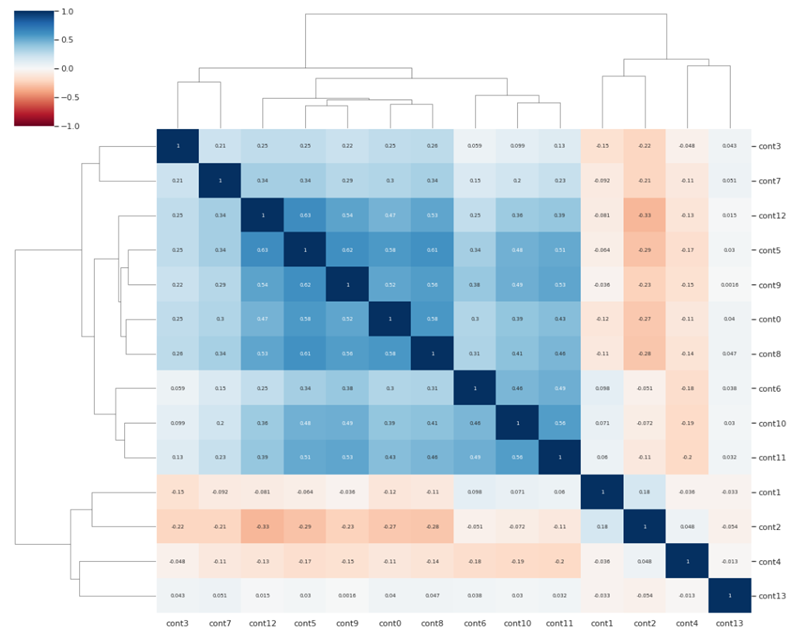

초기에는 cont0~13 변수 각각을 하나의 군집으로 배정한 상태에서 시작하여, 

군집 간 결합 조건으로 두 군집에 포함된 변수간의 피어슨 상관도 절대값의 평균이 0.5이상 일 때, 

피어슨 상관도의 절대값이 높은 것을 우선으로 군집들을 결합한다. 군집의 크기가 가장 큰 변수들을 구하라.


Hint] cont0 ~ 13간의 거리는 [단계 2-1] corr을 이용하여 군집 결합 조건을 고려하여 구한다. 

    (두 변수간에 피어슨 상관도의 절대값이 높을 수록 거리는 가깝다.)

---
**함수가이드**

sklearn.cluster.AgglomerativeClustering

문제 지시사항 외 Default 값 사용

---

In [168]:
# 피어슨 상관도 절대값의 평균이 0.5이상 일 때, -> 거리의 평균이 0.5이하 
df_dist = 1 - df_corr.abs()
from sklearn.cluster import AgglomerativeClustering
clu_agg = AgglomerativeClustering(
    n_clusters=None, 
    affinity= "precomputed",  
    linkage='average', # 거리의 평균
    distance_threshold=0.5 # 0.5 이하 
)
clu_agg.fit(df_dist)

AgglomerativeClustering(affinity='precomputed', compute_full_tree='auto',
                        connectivity=None, distance_threshold=0.5,
                        linkage='average', memory=None, n_clusters=None,
                        pooling_func='deprecated')

In [179]:
X_corr = df_dist[
    clu_agg.labels_ == pd.Series(clu_agg.labels_).value_counts().idxmax()
].index.tolist()
X_corr

['cont0', 'cont5', 'cont8', 'cont9', 'cont12']

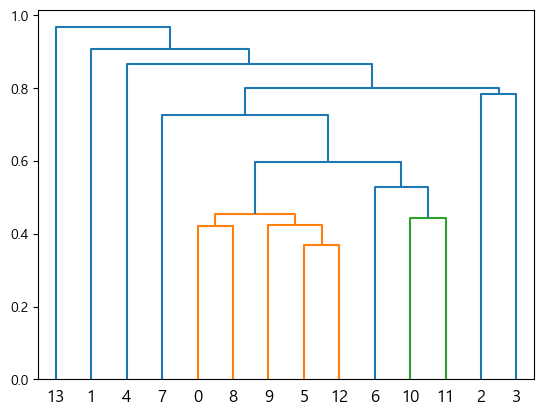

In [180]:
# 속성에 대한 연관성으로 사용하고 있는 방법입니다.
# scipy에 있는 cluster 모듈로 구현해보고
# 속성간에 연관성을 시각화 해봅니다.
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

df_corr = df_basetable[['cont{}'.format(i) for i in range(14)]].corr()
df_dist = 1 - df_corr.abs()

# scipy.cluster hierarchy를 통해 군집화를 합니다.
Z = hierarchy.linkage(squareform(df_dist), method='average')
plt.figure()
# 군집 결합 입계점을 0.5로 하여 색상으로 군집들을 표시합니다.
hierarchy.dendrogram(Z, color_threshold=0.5)
plt.show()

## 단계 2-3

basetable에서 cat0 ~ 9을 각 변수의 첫 번째 범주(알파벳 순)를 제외하고 원핫 인코딩(One-hot encoding)하여 prob2를 만든다.

In [184]:
df_prob2 = pd.get_dummies(df_basetable, columns=cat_cols, drop_first=True)
df_prob2.head()

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,...,cat9_F,cat9_G,cat9_H,cat9_I,cat9_J,cat9_K,cat9_L,cat9_M,cat9_N,cat9_O
id,,,,,,,,,,,,,,,,,,,,,
267387,0.65226,0.55771,0.25398,0.28196,0.82400,0.22443,0.69220,0.30912,0.47134,0.53290,...,0,1,0,0,0,0,0,0,0,0
410037,0.36970,0.68159,0.30038,0.20156,0.46113,0.43278,0.97199,0.62596,0.40193,0.49181,...,1,0,0,0,0,0,0,0,0,0
139373,0.47881,0.63976,0.40024,0.24153,0.27128,0.36238,0.41310,0.27010,0.40112,0.53052,...,0,0,0,0,1,0,0,0,0,0
113765,0.43438,0.77575,0.54887,0.21935,0.27944,0.32670,0.42301,0.28331,0.46425,0.38302,...,0,1,0,0,0,0,0,0,0,0
179915,0.47866,0.64326,0.37255,0.21004,0.41188,0.20121,0.37466,0.46316,0.75578,0.55676,...,0,0,0,0,0,0,1,0,0,0


## 단계 2-4

prob2에서 80%는 학습용 prob2_train으로 20%는 테스트용 prob2_test으로 분리한다.


---
**함수가이드**

sklearn.model_selection.train_test_split, random_state=123

문제 지시사항 외 Default 값 사용

---

In [186]:
from sklearn.model_selection import train_test_split
df_prob2_train, df_prob2_test = train_test_split(df_prob2, train_size=0.8, random_state=123)
df_prob2_train, df_prob2_test = df_prob2_train.copy(), df_prob2_test.copy()

## 단계 2-5

prob2_train으로 [단계 2-2]에서 도출된 변수들로 PCA 모델을 만들고 

분산 설명률이 높은 순으로 누적 분산 설명률이 0.8을 넘기는 최소의 컴포넌트를 prob2_train에 추가 한다. 

동일한 PCA 모델로 prob2_test를 변환하여 같은 수의 컴포넌트를 prob2_test에 추가 한다.

---
**함수가이드**

sklearn.decomposition.PCA (입력의 순서는 cont 뒤의 번호가 낮은 것에서 높은 것 순으로 한다, random_state=123)

문제 지시사항 외 Default 값 사용

----

In [188]:
from sklearn.decomposition import PCA 
pca = PCA(n_components=0.8, random_state=123) # 분산 설명률이 높은 순으로 누적 분산 설명률이 0.8
pca.fit(df_prob2_train[X_corr])
pca.n_components_, pca.explained_variance_ratio_, pca.explained_variance_ratio_.cumsum(), pca.explained_variance_ratio_[:-1].sum()

(3,
 array([0.65539329, 0.10812902, 0.0834131 ]),
 array([0.65539329, 0.76352231, 0.84693541]),
 0.7635223132681558)

In [189]:
X_comp = ['pca_{}'.format(i) for i in range(pca.n_components_)]
df_prob2_train = pd.concat([
    df_prob2_train,
    pd.DataFrame(pca.transform(df_prob2_train[X_corr]), index=df_prob2_train.index, columns=X_comp)
], axis=1)
df_prob2_test = pd.concat([
    df_prob2_test,
    pd.DataFrame(pca.transform(df_prob2_test[X_corr]), index=df_prob2_test.index, columns=X_comp)
], axis=1)

## 단계 2-6

prob2_train에서 target을 선형회귀모델로 학습하고 prob2_test를 다음 성능 지표로 평가한 값을 A라고 한다.

입력변수: cont0 ~ 13, cat0 ~ 9 원핫-인코딩 후 나온 파생 변수 (변수명, 범주명 알파벳 순서)

대상변수: target

성능지표:
 $MSE(Y, \hat{Y}) = \frac{1}{n}\sum^{n}_{i=1}(y_i-\hat{y_i})^2\$
 
Hint] 학습데이터의 형태는 (192,000, 43) 이다. 

---
**함수가이드**

sklearn.linear_model.LinearRegression

문제 지시사항 외 Default 값 사용

---

In [190]:
from sklearn.metrics import mean_squared_error # 성능지표:  𝑀𝑆𝐸
from sklearn.linear_model import LinearRegression
X_lr = cont_cols + [i for i in df_prob2_train.columns if i.startswith('cat')]
reg_lr = LinearRegression()
reg_lr.fit(df_prob2_train[X_lr], df_prob2_train['target'])
A = mean_squared_error(df_prob2_test['target'], reg_lr.predict(df_prob2_test[X_lr]))
(
    A,
    mean_squared_error(df_prob2_train['target'], reg_lr.predict(df_prob2_train[X_lr]))
)

(0.7455022756348629, 0.7446868277591954)

## 단계 2-7

prob2_train에서 cont0 ~ 13 중에서 PCA에서 사용했던 변수를 제외하고 

단계 2-5에서 추가한 PCA 컴포넌트를 포함하여 target로 선형회귀모델을 학습한다. 

prob2_test로 동일한 지표로 대한 성능 평가한 값을 B라 한다.


입력변수: cont0 ~ 13중 PCA에 사용한 것을 제외한 나머지 변수, 

PCA를 통한 파생 변수를 분산 설명력이 높은 순으로, cat0 ~ 9까지 원핫-인코딩 후 나온 파생 변수 (변수명, 범주명 알파벳 순서)

대상변수: target

성능지표:
 $MSE(Y, \hat{Y}) = \frac{1}{n}\sum^{n}_{i=1}(y_i-\hat{y_i})^2\$
 
---
**함수가이드**

sklearn.linear_model.LinearRegression

문제 지시사항 외 Default 값 사용

---


In [193]:
from sklearn.metrics import mean_squared_error # 성능지표:  𝑀𝑆𝐸
from sklearn.linear_model import LinearRegression

# cat으로 시작하는 변수를 뽑을 수도 있지만, 보다 일반적으로 적용할 수 있는 방법을 보여드립니다.
# 가변수명이 만들어지는 규칙을 이용해서 가변수명을 구합니다.
# 이를 통해 첫번째, 마지막 변수를 제외하는 로직으로 확장할 수 있습니다.
# explode 는 Series 요소가 list 구조로 되어 있을 때, 이를 풀어내어 Series구조로 만듭니다.from sklearn.preprocessing import OneHotEncoder
X_dumm = df_basetable[cat_cols].apply(
    lambda x: ['{}_{}'.format(x.name, i) for i in np.sort(x.unique())[1:]], axis=0
).explode().tolist()
X_lr = [i for i in cont_cols if i not in X_corr] + X_comp + X_dumm
reg_lr = LinearRegression()
reg_lr.fit(df_prob2_train[X_lr], df_prob2_train['target'])
B = mean_squared_error(df_prob2_test['target'], reg_lr.predict(df_prob2_test[X_lr]))
(
    B,
    mean_squared_error(df_prob2_train['target'], reg_lr.predict(df_prob2_train[X_lr]))
)

(0.749894456644354, 0.7487573079567996)

In [194]:
A, B, A - B, round(A - B, 3)

(0.7455022756348629, 0.749894456644354, -0.004392181009491014, -0.004)

A-B 를 소수점 넷째 자리에서 반올림하여 셋째 자리까지 구하라.

**-0.004**

# 문제3

전처리 단계에서 target이 두 개의 정규 분포의 혼합한 형태 보이고 있음 확인했고, 

target을 7.45 경계값을 기준으로 A와 B범주로 나누었다. 

Gaussian Mixture라는 모델을 사용하여 두 개 정규 분포의 매개 변수를 측정했고, target의 분포를 시각화했다. 

아래 시각화 그래프에서 A, B가 혼재하여 A 또는 B라고 확신할 수는 없는 구간이 존재한다. 

A 또는 B라고 확신할 수 있는 관측치만을 가지고 A / B를 분류 모델을 만들고자 한다. 다음 단계들을 수행하라.

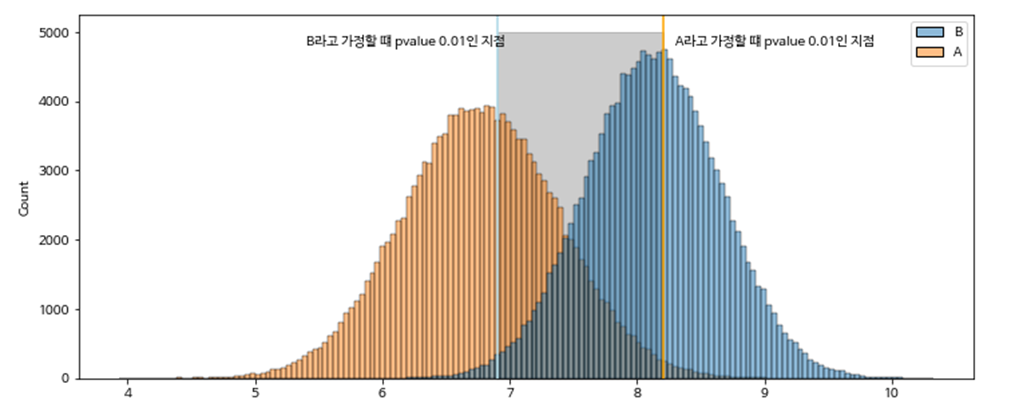

## 단계 3-1

A 범주의 평균은 6.769 표준편차는 0.616이고 범주 B일 때 평균은 8.123 표준편차는 0.527이다. 

측정한 값을 범주A, B의 모집단의 target의 평균과 표준편차라고 가정한다. 

두 개의 정규 분포를 이용하여, 귀무가설이 ‘target은 A 범주에 해당한다’일 때 p-value를 구하여 파생변수(prob_A)를 만든다. 

반대로, 귀무가설이 ‘target은 B 범주에 해당한다’일 때 p-value를 구하여 파생변수(prob_B)를 만든다.

basetable에 두 개의 파생 변수 prob_A, prob_B를 추가하여 prob3 데이터프레임을 만든다.

---
**함수가이드**

scipy.stats 제공 기능 활용

문제 지시사항 외 Default 값 사용

---

In [204]:
from scipy.stats import norm

df_prob3 = df_basetable.assign(
    prob_A = lambda x: 1 - norm.cdf(x['target'], loc=6.769, scale=0.616), # 귀무가설 "target은 A 범주에 해당한다."  = > mu = 6.769, sigma=0.616
    prob_B = lambda x: norm.cdf(x['target'], loc=8.123, scale=0.527)# 귀무가설 "target은 B 범주에 해당한다."  = > mu = 8.123, sigma=0.527
)
df_prob3.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont8,cont9,cont10,cont11,cont12,cont13,target,targetA,prob_A,prob_B
id,,,,,,,,,,,,,,,,,,,,,
267387,A,B,B,C,B,B,A,E,G,G,...,0.47134,0.53290,0.97139,0.59414,0.36856,0.42951,8.13741,False,0.013160,0.510907
410037,A,A,A,A,B,B,A,E,C,F,...,0.40193,0.49181,0.56479,0.39386,0.36247,0.71541,7.40427,True,0.151204,0.086313
139373,A,A,B,A,B,B,A,E,C,J,...,0.40112,0.53052,0.35635,0.33341,0.33354,0.82542,7.98022,False,0.024634,0.393223
113765,A,A,A,C,B,B,A,E,C,G,...,0.46425,0.38302,0.38054,0.68827,0.34895,0.73375,7.26085,True,0.212302,0.050924
179915,A,B,A,C,B,B,A,E,E,L,...,0.75578,0.55676,0.31308,0.43157,0.32302,0.18028,7.26448,True,0.210597,0.051649


## 단계 3-2

prob3 중에서 target이 A 또는 B라고 신뢰할 수 있는 행들만을 골라내고자 한다.

prob_B가 0.01 미만이거나, prob_A가 0.01 미만인 것만 남긴다. (즉, 위 그림에서 회색 영역에 해당하는 부분은 제외)

Hint] 행의 개수는 124,600가 된다.

In [207]:
df_prob3 = df_prob3.query('prob_B < 0.01 or prob_A < 0.01')
df_prob3.shape

(124600, 28)

## 단계 3-3

prob3에 cat0 ~ 9를 제외하는 범주 없이 원핫 인코딩(One-Hot Encoding) 한다. 


In [209]:
df_prob3 = pd.get_dummies(df_prob3, columns=cat_cols)

In [212]:
X_dum = [i for i in df_prob3.columns if i.startswith('cat')]
np.array(X_dum)

array(['cat0_A', 'cat0_B', 'cat1_A', 'cat1_B', 'cat2_A', 'cat2_B',
       'cat3_A', 'cat3_C', 'cat3_D', 'cat4_B', 'cat4_C', 'cat5_A',
       'cat5_B', 'cat5_C', 'cat5_D', 'cat6_A', 'cat6_B', 'cat6_C',
       'cat7_B', 'cat7_D', 'cat7_E', 'cat7_G', 'cat8_A', 'cat8_C',
       'cat8_D', 'cat8_E', 'cat8_G', 'cat9_A', 'cat9_B', 'cat9_F',
       'cat9_G', 'cat9_H', 'cat9_I', 'cat9_J', 'cat9_K', 'cat9_L',
       'cat9_M', 'cat9_N', 'cat9_O'], dtype='<U6')

In [231]:
X_dum = df_basetable[cat_cols].apply(
    lambda x: ['{}_{}'.format(x.name, i) for i in np.sort(x.unique())], axis=0
).explode().tolist()
np.array(X_dum)

array(['cat0_A', 'cat0_B', 'cat1_A', 'cat1_B', 'cat2_A', 'cat2_B',
       'cat3_A', 'cat3_C', 'cat3_D', 'cat4_B', 'cat4_C', 'cat5_A',
       'cat5_B', 'cat5_C', 'cat5_D', 'cat6_A', 'cat6_B', 'cat6_C',
       'cat7_B', 'cat7_D', 'cat7_E', 'cat7_G', 'cat8_A', 'cat8_C',
       'cat8_D', 'cat8_E', 'cat8_G', 'cat9_A', 'cat9_B', 'cat9_F',
       'cat9_G', 'cat9_H', 'cat9_I', 'cat9_J', 'cat9_K', 'cat9_L',
       'cat9_M', 'cat9_N', 'cat9_O'], dtype='<U6')

## 단계 3-4

prob3를 학습용 80%, 그 외 20%는 테스트용으로 나누어 prob3_train, prob3_test로 한다.


---
**함수가이드**

sklearn.model_selection.train_test_split, random_state=123

문제 지시사항 외 Default 값 사용

---

In [229]:
from sklearn.model_selection import train_test_split
df_prob3_train, df_prob3_test = train_test_split(df_prob3, train_size=0.8, random_state=123)

## 단계 3-5

prob3_train으로 targetA를 예측하는 xgboost 분류 모델을 다음과 같은 설정으로 prob3_train를 사용하여 학습한다. 

prob3_test으로 다음 성능지표로 평가한 값을 C 라고 한다.

입력변수: cont0 ~ 13, cat0 ~ 9까지 원핫-인코딩 파생 변수 (변수명, 범주순으로 알파벳 순서)

대상변수: targetA

성능지표: $Accuracy(Y, \hat{Y})=\frac{TP+TN}{TP+FP+TN+FN}$

하이퍼 파라미터(Hyper-Parameter, 초매개변수) 설정: 

|항목|값|
|----|--|
|트리의 최대 깊이|2|
|L1 규제|0.1|
|L2 규제|0.1|
|트리 당 컬럼 샘플링 비율|0.25|
|트리의 수|500|
|random_state|123|

---
**함수가이드**

xgboost 제공 기능 활용

문제 지시사항 외 Default 값 사용

----


In [235]:
from sklearn.metrics import accuracy_score # 성능지표:  𝐴𝑐𝑐𝑢𝑟𝑎𝑐𝑦
import xgboost as xgb
X_xgb = cont_cols + X_dum
clf_xgb = xgb.XGBClassifier(
    max_depth = 2, # 트리의 최대 깊이: 2
    reg_alpha = 0.1, # L1 규제: 0.1
    reg_lambda = 0.1, # L2 규제: 0.1
    colsample_bytree = 0.25, # 트리 당 컬럼 샘플링 비율: 0.25
    n_estimators = 500, # 트리의 수: 500
    random_state=123 # random_state: 123
)
clf_xgb.fit(df_prob3_train[X_xgb], df_prob3_train['targetA'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.25, gamma=0, learning_rate=0.1,
              max_delta_step=0, max_depth=2, min_child_weight=1, missing=None,
              n_estimators=500, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=123, reg_alpha=0.1,
              reg_lambda=0.1, scale_pos_weight=1, seed=None, silent=True,
              subsample=1)

In [236]:
C = accuracy_score(
    df_prob3_test['targetA'], clf_xgb.predict(df_prob3_test[X_xgb])
)
(
    C, 
    accuracy_score(
        df_prob3_train['targetA'], clf_xgb.predict(df_prob3_train[X_xgb])
    )
)

(0.6547351524879614, 0.6661918138041734)

In [238]:
df_prob3_test['targetA'].value_counts(normalize=True).iloc[0]

0.5509630818619583

In [241]:
C, round(C, 3)

(0.6547351524879614, 0.655)

C 를 소수점 넷째 자리에서 반올림하여 셋째 자리까지 출력하라.

**0.655**

# 문제 4
 
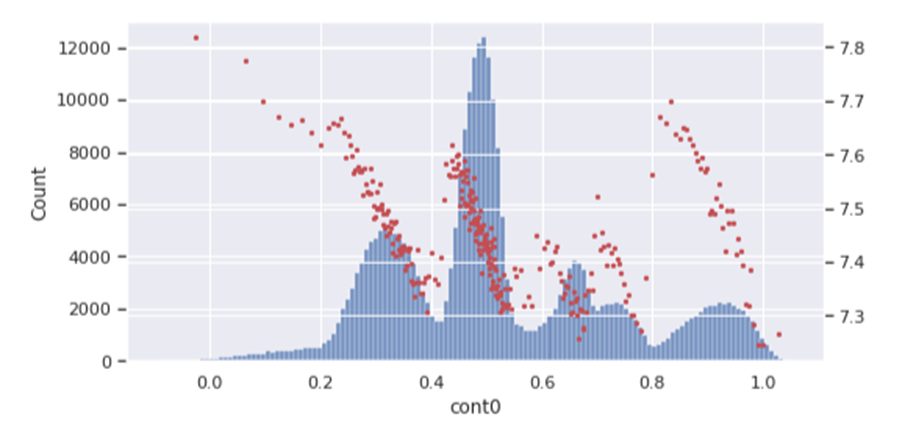

위 차트는 cont0 의 히스토그램과 cont0를 300개의 분위 구간으로 나누어 x값은 분위 구간의 중간값, 

y값은 분위 구간에서 target의 평균을 산포도 그래프로 동시에 출력했다. 

좌측 y축은 히스토그램의 빈도수이고, 우측 y축은 target의 평균이다. 

히스토그램에서 동일한 봉우리 구간 내에서 cont0와 target간에 선형적 관계가 있음이 확인되었다. 

이 점을 이용하여 파생 변수를 만들어서 회귀모델을 만들어 간다.

## 단계 4-1

basetable에서 cat0 ~ 9을 첫 번째 범주(알파벳 순)는 제외하고 원핫 인코딩(One-Hot Encoding)하여 prob4데이터셋을 만든다.

In [317]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(drop='first', sparse=False)
ohe.fit(df_basetable[cat_cols])

X_dum = ohe.get_feature_names(cat_cols)
df_prob4 = pd.concat([
    df_basetable.drop(columns=cat_cols),
    pd.DataFrame(
        ohe.transform(df_basetable[cat_cols]), 
        index =df_basetable.index, columns = X_dum
    )
], axis=1)
df_prob4.head()

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,...,cat9_F,cat9_G,cat9_H,cat9_I,cat9_J,cat9_K,cat9_L,cat9_M,cat9_N,cat9_O
id,,,,,,,,,,,,,,,,,,,,,
267387,0.65226,0.55771,0.25398,0.28196,0.82400,0.22443,0.69220,0.30912,0.47134,0.53290,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
410037,0.36970,0.68159,0.30038,0.20156,0.46113,0.43278,0.97199,0.62596,0.40193,0.49181,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
139373,0.47881,0.63976,0.40024,0.24153,0.27128,0.36238,0.41310,0.27010,0.40112,0.53052,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
113765,0.43438,0.77575,0.54887,0.21935,0.27944,0.32670,0.42301,0.28331,0.46425,0.38302,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
179915,0.47866,0.64326,0.37255,0.21004,0.41188,0.20121,0.37466,0.46316,0.75578,0.55676,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [265]:
# 사전순으로 마지막 범주값을 제외하여 가변수화 하시오
last_cat = df_basetable[cat_cols].apply(
    lambda x: np.sort(x.unique())[-1], axis=0
).tolist()
ohe = OneHotEncoder(drop=last_cat, sparse=False)
ohe.fit(df_basetable[cat_cols])
pd.concat([
    df_basetable.drop(columns=cat_cols),
    pd.DataFrame(
        ohe.transform(df_basetable[cat_cols]), 
        index =df_basetable.index, columns = ohe.get_feature_names(cat_cols)
    )
], axis=1).iloc[:, -len(ohe.get_feature_names(cat_cols)):]

,cat0_A,cat1_A,cat2_A,cat3_A,cat3_C,cat4_B,cat5_A,cat5_B,cat5_C,cat6_A,...,cat9_B,cat9_F,cat9_G,cat9_H,cat9_I,cat9_J,cat9_K,cat9_L,cat9_M,cat9_N
id,,,,,,,,,,,,,,,,,,,,,
267387,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
410037,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
139373,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
113765,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
179915,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320975,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
29591,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46717,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 단계 4-2

prob4의 80%를 prob4_train으로 20% prob4_test로 나눈다.

---
**함수가이드**

sklearn.model_selection.train_test_split, random_state=123

---

In [266]:
from sklearn.model_selection import train_test_split
df_prob4_train, df_prob4_test = train_test_split(df_prob4, train_size=0.8, random_state=123)
df_prob4_train, df_prob4_test = df_prob4_train.copy(), df_prob4_test.copy()

## 단계 4-3

prob4_train에서 cont0를 100개의 우측이 닫힌 (ex. i번째 분위수 < cont0 ≤ i+1 번째 분위수) 분위 구간으로 나누고 

각각의 분위 구간에서 target의 평균을 구해 파생 변수 cont0_q를 만든다. 

prob4_test에는 prob4_train을 나누었던 구간 설정과 구간의 평균으로 cont0_q를 만든다. 

이 때, prob4_test의 cont0값이 train의 첫 번째 구간보다 작다면, 첫 번째 구간으로 간주하고, 

마지막 구간보가 크다면, 마지막 구간으로 간주한다.

---
**함수가이드**

Hint 1] pandas.Series.quantile, pandas.cut 활용을 권장한다.

Hint 2] 두 번째 분위 구간은 0.111 < cont0 <= 0.176이고 target의 평균은 7.672 (셋째 자리까지 반올림)

Hint 3] cont0_q의 평균은 7.46, 표준 편차는 0.10 (소수점 둘째 자리까지 반올림)

---

In [334]:
q = np.arange(0, 101) / 100 # np.linspace(0, 1, 101)
q_val =  df_prob4_train['cont0'].quantile(q)
q_val.iloc[[0, -1]] = [-np.inf , np.inf]
q_range = pd.cut(df_prob4_train['cont0'], q_val, right=True)
q_mean = df_prob4_train.groupby(q_range)['target'].agg('mean')
df_prob4_train['cont0_q'] = q_range.map(q_mean).astype('float')
df_prob4_test['cont0_q'] = pd.cut(df_prob4_test['cont0'], q_val, right=True).map(q_mean)

In [335]:
pd.concat([
        df_prob4_train['cont0'].iloc[:5],
        q_range.iloc[:5].rename('cont0_lab'),
        q_range.iloc[:5].map(q_mean).astype('float').rename('cont0_q')
    ], axis=1
)

,cont0,cont0_lab,cont0_q
id,,,
487693,0.49355,"(0.492, 0.494]",7.449876
307175,0.66260,"(0.662, 0.669]",7.306663
493409,0.87161,"(0.871, 0.885]",7.612856
414858,0.51951,"(0.517, 0.52]",7.352864
408161,0.86293,"(0.854, 0.871]",7.638234


## 단계 4-4

단계 4-3에서 cont0_q를 만든 것처럼 나머지 변수 cont1~13에 대해서도 파생변수를 생성한다.

생성한 파생 변수명은 원래의 변수명에 _q를 결합한다. (ex. cont1 -> cont1_q)

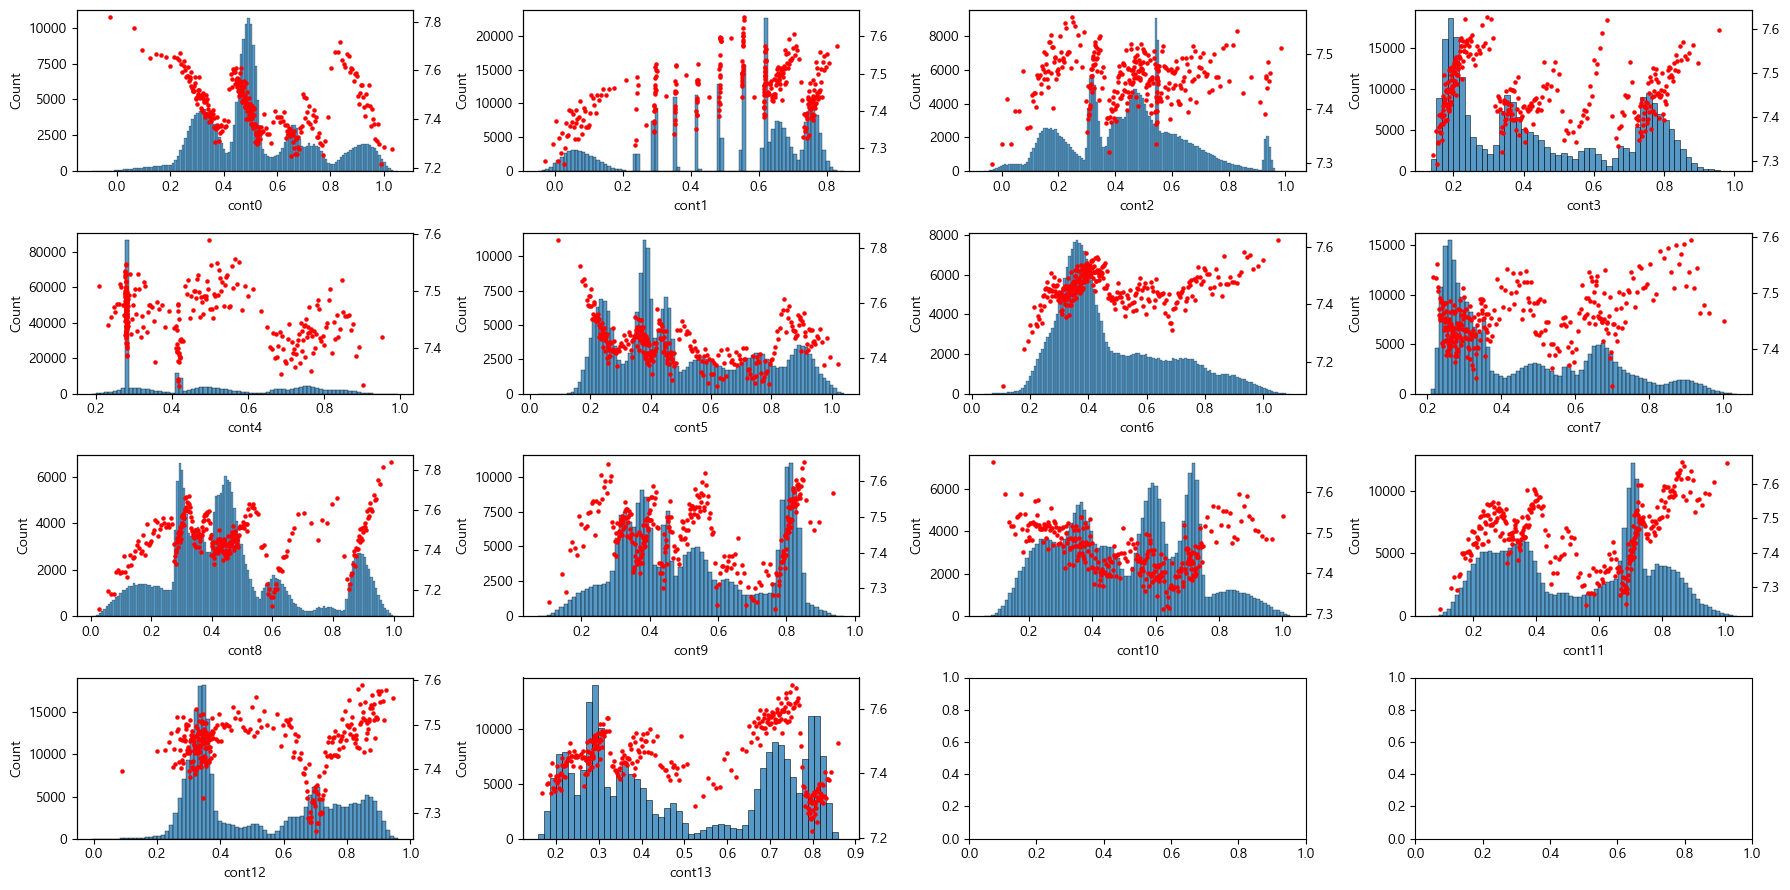

In [307]:
# 다른 변수에 대해서도 그래프를 출력합니다.

fig, axes = plt.subplots(4, 4, figsize=(18, 9))
for i, ax in enumerate(axes.ravel()[:14]):
    col = 'cont{}'.format(i)
    sns.histplot(data=df_train, x=col, ax=ax)
    tmp = df_train.groupby(pd.qcut(df_train[col], q=300))[['target']].mean()
    ax.twinx().scatter((tmp.index.categories.left + tmp.index.categories.right) / 2, 
                       tmp['target'], c='r', s=5)
plt.tight_layout()
plt.show()

In [328]:
q = np.arange(0, 101) / 100 # np.linspace(0, 1, 101)
for i in cont_cols:
    q_val =  df_prob4_train[i].quantile(q)
    q_val.iloc[[0, -1]] = [-np.inf , np.inf]
    q_range = pd.cut(df_prob4_train[i], q_val, right=True)
    q_mean = df_prob4_train.groupby(q_range)['target'].agg('mean')
    df_prob4_train[i + '_q'] = q_range.map(q_mean)# .astype('float')
    df_prob4_test[i + '_q'] = pd.cut(df_prob4_test[i], q_val, right=True).map(q_mean)

## 단계 4-5

prob4_train에서 target을 대상으로 선형회귀모델을 학습하고, 

prob4_test를 다음 지표로 성능 평가한 값을 D라고 한다. 

선형회귀 모델은 아래와 같은 손실함수로 학습을 한다.

$||Xw - y||^2_2 + \alpha||w||^2_2, \alpha = 0.1$

Hint] sklearn.linear_model.Ridge 또는 Lasso 중 요건에 맞는 것을 사용한다. 

입력 변수: cont0_q ~ cont13_q, cat0 ~ 9까지 원핫-인코딩 후 나온 파생 변수 (변수명 다음 범주명으로 알파벳 순서이다)

대상 변수: target

성능 지표: $MSE(Y, \hat{Y}) = \frac{1}{n}\sum^{n}_{i=1}(y_i-\hat{y_i})^2\$


In [329]:
from sklearn.metrics import mean_squared_error # 성능 지표:  𝑀𝑆𝐸
from sklearn.linear_model import Ridge

X_rd = [i + '_q' for i in cont_cols] + X_dum.tolist()
reg_rd = Ridge(alpha = 0.1)
reg_rd.fit(df_prob4_train[X_rd], df_prob4_train['target'])
D = mean_squared_error(df_prob4_test['target'], reg_rd.predict(df_prob4_test[X_rd]))
(
    D,
    mean_squared_error(df_prob4_train['target'], reg_rd.predict(df_prob4_train[X_rd]))
)

(0.7211658399136686, 0.7133971363485151)

In [320]:
D, round(D, 2)

(0.7211658399136686, 0.72)

D를 소수점 셋째 자리에서 반올림하여 둘째 자리까지 출력하라.

**0.72**

In [339]:
# target의 값을 가지고 파생변수를 만든다면, Leak을 유의하셔야 합니다.
# 만인 df_prob4_train을 가지고 교차 검증을 통해 모델을 성능을 측정하고자 한다면,
# df_prob4_train에 있는 cont{}_q 들은 df_prob4_train['target']을 가지고 파생변수를 만들었는데요,
# 교차 검증을 한다면, 이는 겹외 셋의 target 값이 사전에 cont{}_q에 반영이 된 겁니다.
# 이점이 바로 leak으로 작용하는 겁니다.
# 이 Leak으로 교차 검정 결과에 왜곡이 생깁니다.
# 검증은 실제 테스트를 잘 반영해야하는데요,
# 측정 결과는 위 df_prob4_test를 반영한다고 보기 힘듭니다.

from sklearn.model_selection import cross_val_score, KFold
cv = KFold(n_splits=5, random_state=123, shuffle=True)
X_rd = [i + '_q' for i in cont_cols] + X_dum.tolist()
score_ = cross_val_score(
    reg_rd, 
    df_prob4_train[X_rd], 
    df_prob4_train['target'], 
    cv=cv, scoring='neg_mean_squared_error'
)
-np.mean(score_)

0.7137604473647997

In [341]:
# 위에서 발생한 leak을 바로 잡아 교차검증을 합니다.
q = [i for i in np.arange(0, 1.01, 0.01)]
score_ = []
X_rd = [i + '_q' for i in cont_cols] + X_dum.tolist()
reg_rd = Ridge(alpha=0.1)
for train_idx, valid_idx in cv.split(df_prob4_train):
    df_cv_train, df_valid = df_prob4_train.iloc[train_idx].copy(), df_prob4_train.iloc[valid_idx].copy()
    # 검증셋에서 train으로 파생변수를 만들고
    # 검증셋의 test(겹외셋)에 검증셋의 train으로 만든 통계값(mean)을 반영합니다.
    for i in range(0, 14):
        col = 'cont{}'.format(i)
        qt = df_cv_train[col].quantile(q)
        qt.iloc[[0, -1]] = [-np.inf, np.inf]
        q_range = pd.cut(df_cv_train[col], bins=qt)
        q_mean = df_cv_train.groupby(q_range)['target'].mean()
        df_cv_train[col + '_q'] = q_range.map(q_mean).astype('float')
        df_valid[col + '_q'] = pd.cut(df_valid[col], bins=qt).map(q_mean).astype('float')
    reg_rd.fit(df_cv_train[X_rd], df_cv_train['target'])
    score_.append(mean_squared_error(df_valid['target'], reg_rd.predict(df_valid[X_rd])))
# leak을 제거하니 위 df_prob4_test의 성능에 가깝게 나옵니다.
# leak을 없애 것이 이 검증이 Test에서 상황을 좀 더 잘 반영하게 된것입니다.
np.mean(score_), score_

(0.7213562985785656,
 [0.7117010644566664,
  0.723611793945826,
  0.7246524557901771,
  0.7271922710505178,
  0.7196239076496412])

**Tip! 사용자 정의 지표를 만들어봅니다**

시험장 버젼 sklearn에는 mape가 구현되어 있지 않습니다.

$MAPE=\frac{100}{N}\sum_{i=1}^{n}|\frac{y-\hat{y}}{y}|$

In [346]:
from sklearn.metrics import make_scorer
def mape(y_true, y_prd):
    return np.mean(
        np.abs((y_true - y_prd) / y_true)
    ) * 100

mape_scorer = make_scorer(mape, greater_is_better=False)

cv = KFold(n_splits=5, random_state=123, shuffle=True)
X_rd = [i + '_q' for i in cont_cols] + X_dum.tolist()
score_ = cross_val_score(
    reg_rd, 
    df_prob4_train[X_rd], 
    df_prob4_train['target'], 
    cv=cv, scoring=mape_scorer
)
score_, -np.mean(score_)

(array([-9.70891848, -9.77411863, -9.78520922, -9.82802403, -9.7602062 ]),
 9.77129531342239)

In [348]:
score_ = []
X_rd = [i + '_q' for i in cont_cols] + X_dum.tolist()
reg_rd = Ridge(alpha=0.1)
for train_idx, valid_idx in cv.split(df_prob4_train):
    df_cv_train, df_valid = df_prob4_train.iloc[train_idx].copy(), df_prob4_train.iloc[valid_idx].copy()
    reg_rd.fit(df_cv_train[X_rd], df_cv_train['target'])
    score_.append(mape(df_valid['target'], reg_rd.predict(df_valid[X_rd])))
np.mean(score_), score_

(9.77129531342239,
 [9.708918480936667,
  9.774118632853558,
  9.785209218322946,
  9.828024033602958,
  9.760206201395825])

# 문제 5


XGBoost 분류 모델의 최적의 하이퍼 파라미터(Hyper-Parameter, 초매개변수)를 탐색한다.

## 단계 5-1

basetable에 cat0 ~ 9 제외하는 범주 없이 원핫 인코딩(One-Hot Encoding) 하여 prob5를 만든다.


In [349]:
df_prob5 = pd.get_dummies(df_basetable, columns=cat_cols)
X_dum = df_basetable[cat_cols].apply(
    lambda x: ['{}_{}'.format(x.name, i) for i in np.sort(x.unique())]
    ,axis = 0
).explode().tolist()
df_prob5.head()

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,...,cat9_F,cat9_G,cat9_H,cat9_I,cat9_J,cat9_K,cat9_L,cat9_M,cat9_N,cat9_O
id,,,,,,,,,,,,,,,,,,,,,
267387,0.65226,0.55771,0.25398,0.28196,0.82400,0.22443,0.69220,0.30912,0.47134,0.53290,...,0,1,0,0,0,0,0,0,0,0
410037,0.36970,0.68159,0.30038,0.20156,0.46113,0.43278,0.97199,0.62596,0.40193,0.49181,...,1,0,0,0,0,0,0,0,0,0
139373,0.47881,0.63976,0.40024,0.24153,0.27128,0.36238,0.41310,0.27010,0.40112,0.53052,...,0,0,0,0,1,0,0,0,0,0
113765,0.43438,0.77575,0.54887,0.21935,0.27944,0.32670,0.42301,0.28331,0.46425,0.38302,...,0,1,0,0,0,0,0,0,0,0
179915,0.47866,0.64326,0.37255,0.21004,0.41188,0.20121,0.37466,0.46316,0.75578,0.55676,...,0,0,0,0,0,0,1,0,0,0


**Tip! 열방향 groupby**

groupby axis=1로 주면 열을 기준으로 groupby를 하게 됩니다. 

입력 변수가 굉장히 많고, 변수명에 규칙성이 있다면 열방향 GroupBy를 활용하면 

구현 시간을 줄일 수 있습니다.

Ex) 가변수명을 활용해서 범주의 범주값들이 행마다 등장한 횟수를 추출합니다.

    그리고, target과 pearson 상관도 분석을 해봅니다.

In [361]:
# df_prob5[X_dum].T.groupby([i.split('_')[-1] for i in X_dum]).sum().T
df_prob5[X_dum].groupby([i.split('_')[-1] for i in X_dum], axis=1).sum()

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O
id,,,,,,,,,,,,,,,
267387,2,4,1,0,1,0,2,0,0,0,0,0,0,0,0
410037,5,2,1,0,1,1,0,0,0,0,0,0,0,0,0
139373,4,3,1,0,1,0,0,0,0,1,0,0,0,0,0
113765,4,2,2,0,1,0,1,0,0,0,0,0,0,0,0
179915,3,3,1,0,2,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320975,4,2,2,0,1,0,0,0,1,0,0,0,0,0,0
29591,3,3,2,0,1,1,0,0,0,0,0,0,0,0,0
46717,2,3,1,1,1,1,1,0,0,0,0,0,0,0,0


In [363]:
from scipy.stats import pearsonr
df_prob5[X_dum].groupby([i.split('_')[-1] for i in X_dum], axis=1).sum().apply(
    lambda x: pd.Series(pearsonr(x, df_prob5['target']), index=['corr', 'pvalue']), axis=0
)

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O
corr,-0.123781,0.101553,2.234329e-02,2.105080e-02,2.978301e-02,2.017009e-02,-4.309416e-02,-0.002058,-6.669296e-02,-2.005445e-02,-1.977614e-02,0.081757,0.003942,0.001192,-0.004930
pvalue,0.000000,0.000000,6.850167e-28,6.101729e-25,3.075829e-48,4.970866e-23,5.052612e-99,0.313303,1.163493e-234,8.737671e-23,3.351849e-22,0.000000,0.053475,0.559111,0.015725


In [385]:
df_basetable[cat_cols].reset_index().melt(id_vars='id')\
    .pivot_table(index='id', columns='value', aggfunc='size', fill_value=0).apply(
    lambda x: pd.Series(pearsonr(x, df_basetable.sort_index()['target']), index=['corr', 'pvalue']), axis=0
)

value,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O
corr,-0.123781,0.101553,2.234329e-02,2.105080e-02,2.978301e-02,2.017009e-02,-4.309416e-02,-0.002058,-6.669296e-02,-2.005445e-02,-1.977614e-02,0.081757,0.003942,0.001192,-0.004930
pvalue,0.000000,0.000000,6.850167e-28,6.101729e-25,3.075829e-48,4.970866e-23,5.052612e-99,0.313303,1.163493e-234,8.737671e-23,3.351849e-22,0.000000,0.053475,0.559111,0.015725


## 단계 5-2

prob5를 80%는 학습용 prob5_train으로, 20%는 테스트용 prob5_test로 나눈다.

---
**함수가이드**

sklearn.model_selection.train_test_split, random_state=123

문제 지시사항 외 Default 값 사용

---

In [386]:
from sklearn.model_selection import train_test_split
df_prob5_train, df_prob5_test = train_test_split(df_prob5, train_size=0.8, random_state=123)

## 단계 5-3

다음 회귀 분석 모델을 아래 3개의 하이퍼 파라미터(Hyper-Parameter, 초매개변수)를 사용하여 

prob5_train으로 target를 학습시킨다.

prob5_test으로 테스트했을 때 , 최적의 성능을 낸 하이퍼 파라미터 셋의 번호를 A, 성능지표를 B라고 한다.

입력 변수] cont0~13, cat0 ~ 9을 원핫 인코딩하여 나온 파생 변수(변수명, 범주명 알파벳순)


대상 변수] target


성능 지표] $MSE(Y, \hat{Y}) = \frac{1}{n}\sum^{n}_{i=1}(y_i-\hat{y_i})^2\$
 
|No|하이퍼 파라미터(Hyper-parameter, 초매개변수)|
|--|--------------------------------------------|
|1|colsample_bytree=0.25, n_estimators=300|
|2|colsample_bytree=0.5, n_estimators=300|
|3|colsample_bytree=0.25, n_estimators=500|

공통적으로 트리의 최대 깊이는 2, 랜덤 시드는 123 이다.

---
**함수가이드**

xgboost 제공 기능 활용

문제 지시사항 외 Default 값 사용

---

In [388]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error # 성능 지표:  𝑀𝑆𝐸(𝑌,𝑌̂)
X_xgb = cont_cols + X_dum
params = [
    {'colsample_bytree': 0.25, 'n_estimators' :300},
    {'colsample_bytree': 0.5, 'n_estimators': 300},
    {'colsample_bytree': 0.25, 'n_estimators': 500}
]
test_error, train_error = list(), list()
for param in params:
    reg_xgb = xgb.XGBRegressor(
        max_depth=2, # 공통적으로 트리의 최대 깊이는 2, 
        random_state=123, # 랜덤 시드는 123 이다.
        **param
    )
    reg_xgb.fit(df_prob5_train[X_xgb], df_prob5_train['target'])
    test_error.append(mean_squared_error(df_prob5_test['target'], reg_xgb.predict(df_prob5_test[X_xgb])))
    train_error.append(mean_squared_error(df_prob5_train['target'], reg_xgb.predict(df_prob5_train[X_xgb])))
    print(param, test_error[-1], train_error[-1]) 

{'colsample_bytree': 0.25, 'n_estimators': 300} 0.7215793793731834 0.7172290699688967
{'colsample_bytree': 0.5, 'n_estimators': 300} 0.721219679405562 0.7166355943476501
{'colsample_bytree': 0.25, 'n_estimators': 500} 0.7164353991627278 0.710087034418028


In [389]:
A = np.argmin(test_error) + 1
B = np.min(test_error)
A, B, A + B, round(A + B, 2)

(3, 0.7164353991627278, 3.716435399162728, 3.72)

A + B 를 소수점 셋째 자리에서 반올림하여 둘째 자리까지 구하라.

**3.72**